# NeuralGCM：快速開始進行預報

這個python notebook使用ERA5資料與預訓練的NeuralGCM模型來進行天氣預報。

這個預報分為三個主要步驟：

1. 取得ERA5資料，並重採樣到模型所要求的解析度
1. 初始化NeuralGCM模型的狀態，並進行預測
1. 將預測結果與參考結果結合，並進行視覺化

這裡使用決定性（deterministic） NeuralGCM 1.4°模型進行演示。其他可用的檢查點包括deterministic 0.7°、2.8°和stochastic 1.4° NeuralGCM。

## 首先先安裝所需的套件

In [ ]:
!pip install gcsfs
!pip install neuralgcm
!pip install "jax==0.4.33"

## 引入套件

需要引入以下套件，各套件說明如下：

- gcsfs: 用於從Google Cloud Storage下載ERA5資料與NeuralGCM模型
- jax: jax是一個用於自動微分的Python套件，並且支援GPU/TPU加速
- numpy: 用於數學運算
- pickle: 用以將變數儲存到檔案中，並且可以在之後將其讀取回來
- xarray: 用於處理時空資料
- dinosaur: Dinosaur是一個以譜方法為動力核心的全球大氣模型，使用 JAX 編寫。
- neuralgcm: NeuralGCM是一個基於神經網絡的大氣模型。

接著，對於google cloud storage檔案的存取，因為是要存取公開資料集(ERA5)，所以不需要設定金鑰，將token設為anon即可

In [12]:
import gcsfs
import jax
import numpy as np
import pickle
import xarray

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

gcs = gcsfs.GCSFileSystem(token='anon')

> 補充：gcs可以提供一些方法，快速存取google cloud storage的檔案，例如`gcs.ls`可以列出指定路徑下的所有檔案，我們可以在公開資料及內找到。

> 補充：ERA5資料集的路徑為`gs://gcp-public-data-arco-era5/`，若需要關於儲存在google公開資料及內的ERA5詳細說明，可參考：https://cloud.google.com/storage/docs/public-datasets/era5

> 補充：ERA5資料集有三種版本，分別是直接從ECMWF下載的原始檔（存放在`raw`）、經過雲端優化的檔案（存放在`co`）以及隨時可用於分析的檔案（存放在`ar`）。

## 載入預訓練模型

預訓練模型檢查點可在Google Cloud Storage上下載：

- 決定性預報
  - gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl
  - gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl
  - gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl
- 隨機預報
  - gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl

> 解釋：檢查點(Checkpoints)-檢查點是模型在訓練過程中的某個時間點的快照，可以理解為，這是2024/04/30這個時間點所做出的模型。

> 注意：預訓練模型的參數具有著作權，僅限非商業使用。

In [13]:
# 選擇一個要使用的模型之模型名稱
# model_name = 'neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl'
# model_name = 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl' 
# model_name = 'neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl'
model_name = 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl'

# 從 GCS 下載該模型之檢查點（checkpoint）
with gcs.open(f'gs://gresearch/neuralgcm/04_30_2024/{model_name}', 'rb') as f:
  ckpt = pickle.load(f)

# 以該檢查點實例化neuralgcm的PressureLevelModel物件
model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

## 從GCP載入ERA5資料

關於更多資料準備的細節，請參考Data preparation。

選擇指定日期的ERA5資料，並將其下載到本機。

流程圖：下載全體ERA5資料 -> 切出指定的時間空間與變數 -> 重採樣到模型所需的解析度 -> 算出模式需要的網格型態 -> 建立一個內插器（轉換器）用來將ERA5資料轉換成模型所需的網格 -> 將資料利用內插器轉換成模型所需的網格

In [14]:
# 在此，要下載全部的ERA5資料，但這是不可能的（想也知道），所以這邊是Zarr格式的ERA5資料。
# 相當於建立了一個虛擬的全體ERA5資料，當我們要取用哪些時段、變數等特定資料時，他才會真的下載該特定資料。
era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)

# 這邊是設定要使用的ERA5資料的時間範圍（其實只有第一筆資料要投入預報，其餘用來校驗）
demo_start_time = '2020-02-14'
demo_end_time = '2020-02-18'
data_inner_steps = 24  # 每24小時取一次數據

# 看似是從全體ERA5資料切出指定資料，但實際上這邊不只是切出指定資料，還是將該特定資料真的下載下來
sliced_era5 = (
    full_era5 # 從完整的ERA5資料中
    [model.input_variables + model.forcing_variables] # 取出指定變數，包含預報變數['geopotential', 'specific_humidity', 'temperature', 'u_component_of_wind', 'v_component_of_wind', 'specific_cloud_ice_water_content', 'specific_cloud_liquid_water_content']與Forcing變數['geopotential', 'specific_humidity', 'temperature', 'u_component_of_wind', 'v_component_of_wind', 'specific_cloud_ice_water_content', 'specific_cloud_liquid_water_content']
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift='24 hours',
    )
    .sel(time=slice(demo_start_time, demo_end_time, data_inner_steps)) # 取出指定時間範圍(2020-02-14 ~ 2020-02-18)，並且每24小時取一次
    .compute()
)

將下載的資料重採樣到NeuralGCM模型所要求的網格與解析度。

In [15]:
# 根據ERA5資料的網格型態，判斷要建立的球諧函數網格類型，這有關於模式在進行動力求解時的計算方法
# 簡單來說：ERA5的網格長怎樣
era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'], # 網格的緯度方向格點數（721）
    longitude_nodes=full_era5.sizes['longitude'], # 網格的經度方向格點數（1440）
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude), # 判斷緯距是否均勻（是均勻的，且包含極區）
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude), # 判斷經度是否從0度開始（是從0度開始）
)

# 將ERA5資料內差到NeuralGCM的網格上。
# 簡單來說：我就根據ERA5的網格產生對應的網格內插器
regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)

# 將ERA5資料內差到NeuralGCM的網格上，並且將缺失值填補為最近的值 (校驗用)
# 簡單來說：最後利用內插器進行內插，並且將缺失值填補為最近的值
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

## 進行預報

預報的詳細流程，請參考Deep-dive into trained models。

流程圖：設定輸出的時間點 -> 將內插器轉換後的模型網格（氣壓座標）轉換為(Sigma座標)，作為模式要輸入的初始狀態 -> 設定預報的Forcing變數 -> 進行預報 -> 將預報結果轉換成xaarray格式

In [ ]:
# 設定輸出的時間點
inner_steps = 24  # 每隔幾小時輸出一次預報
outer_steps = 4 * 24 // inner_steps  # 總共要輸出多少次預報（次數*每多久輸出一次=總預報時數）
timedelta = np.timedelta64(1, 'h') * inner_steps # 將字串的時間間隔轉為時間資料
times = (np.arange(outer_steps) * inner_steps) # 第幾小時時輸出預報（0, 24, 48, 72）

# 編碼出模式的初始狀態（建立NeuralGCM看得懂的初始場）
inputs = model.inputs_from_xarray(eval_era5.isel(time=0)) # 利用經過內差的ERA5資料，取出第一筆資料，並轉換為模式可以使用的初始場(預報變數)
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0)) # 利用經過內差的ERA5資料，取出第一筆資料，並轉換為模式可以使用的初始場(Forcing變數):這邊是用來初始化時讓初始場也有Forcing變數
rng_key = jax.random.key(42)  # 如果是隨機模式，則需要決定一個隨機種子，但如果是決定性模式則不作用
initial_state = model.encode(inputs, input_forcings, rng_key) # 將預報變數與Forcing變數及編碼成模式的初始狀態

# 設定預報的Forcing變數
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))  # 利用經過內差的ERA5資料，取出第一筆資料設為模式初始場(Forcing變數):這邊是用來讓模式在積分時知道這是Forcing變數

# 進行預報：預報需要投入初始場、Forcing變數、總共要輸出多少次預報、時間間隔、初始場是否記為一次預報
final_state, predictions = model.unroll(
    initial_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True, # 輸出是否要包含初始場（註：如果設定總共輸出四次，那只有三次是預報結果，第一次會是初始場）
)

# 將預報結果轉換為xarray格式
predictions_ds = model.data_to_xarray(predictions, times=times)

> 注意：model.data_to_xarray(predictions, times=times)並不是真的完成預報，他執行完這行只能相當於告訴電腦要進行預報，然後開始計算。直到你之後要讀取輸出時，讀取輸出的程式碼會等待模型計算完畢後再進行。

## 與ERA5再分析資料進行比較

以下展示如何做個簡單的比較

/Users/ericlwc/opt/anaconda3/envs/neuralgcm/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


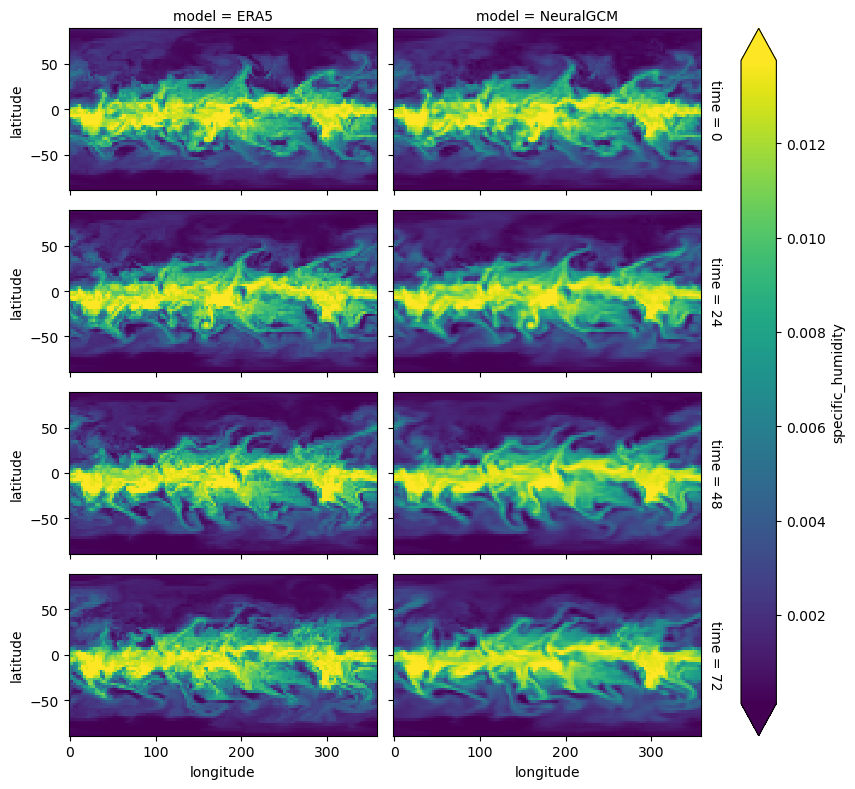

In [22]:
# 將ERA5資料作為預報的正解，轉換為xarray格式
target_trajectory = model.inputs_from_xarray(
    eval_era5
    .thin(time=(inner_steps // data_inner_steps))
    .isel(time=slice(outer_steps))
)
target_data_ds = model.data_to_xarray(target_trajectory, times=times)

# 合併預報的xarray與正解的xarray
combined_ds = xarray.concat([target_data_ds, predictions_ds], 'model')
combined_ds.coords['model'] = ['ERA5', 'NeuralGCM']

# 展示預報結果
combined_ds.specific_humidity.sel(level=850).plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2
)